In [1]:
import numpy as np
from scipy.optimize import minimize
from scipy.optimize import fsolve
from matplotlib import pyplot as plt
import pandas as pd

10.771318054199217


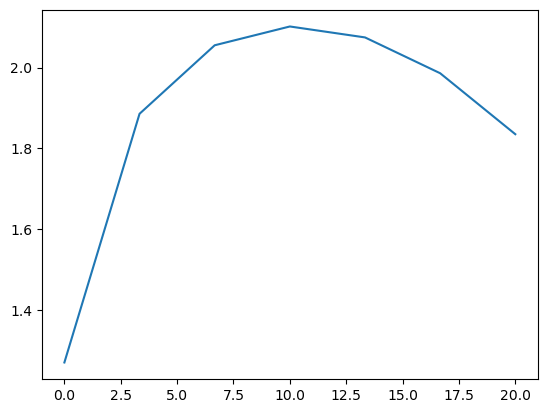

In [2]:
#solve nash bargaining with one insurer

def calc_shares1(p1, cost, wtp):
    """compute the proportion of people choosing each insurer
    assumes interior solution"""
    u1 = (wtp - p1)/cost
    s1 = 2*np.exp(u1)/(2*np.exp(u1) + 1 )
    return s1
  

def calc_profits_price_shares1(phi1,cost,wtp,mc1):
    pi1 = lambda p : -1*calc_shares1(p, cost, wtp)[0]*(p-phi1 -mc1)
    p1 = minimize(pi1,1,method='Nelder-Mead',tol=1e-6).x
    s1 = calc_shares1(p1,  cost, wtp)
    return p1[0], s1[0], s1[0]*(p1[0]-phi1 -mc1)

def nash_in_nash_obj1(phi1, cost, wtp, mc1, beta=.5):
    p1,s1,profits1 = calc_profits_price_shares1(phi1, cost, wtp, mc1)
    hosp_profit = s1*phi1
    obj = -1*(np.log(max(hosp_profit,1e-6))*(1-beta) + np.log(max(profits1,1e-6))*beta)

    #print(obj)
    return obj

def nash_in_nash1(cost,wtp,mc1,outside_option=False):
    obj1 = lambda phi : nash_in_nash_obj1(phi,cost,wtp,mc1)
    result = minimize(obj1,13,method='Nelder-Mead',tol=1e-6)
    
    if outside_option:
        return result.x[0]*calc_shares1(result.x[0], cost, wtp)
    return result.x[0]

print(nash_in_nash1(5,25,0))

COST = 5
WTP1 = 25
MC1 = 0

plt.plot([i for i in np.linspace(0,4*COST,num=7)], 
         [-1*nash_in_nash_obj1(i, COST,WTP1,MC1) for i in np.linspace(1,4*COST,num=7)])

In [3]:
#solve nash bargaining with 2 insurers

def calc_shares(p1, p2,  cost, wtp):
    """compute the proportion of people choosing each insurer
    assumes interior solution"""
    u1 = (wtp[0] - p1)/cost
    u2 = (wtp[1] - p2)/cost
    s1 = np.exp(u1)/(np.exp(u1)+ np.exp(u2) + 1 )
    s2 = np.exp(u2)/(np.exp(u1)+ np.exp(u2) + 1 )
    
    return s1,s2
  

def calc_profits_price_shares(phi1,phi2,cost,wtp,mc):
    mc1,mc2 = mc
    
    p1,p2 = 1,2
    diff =  np.maximum(p1,p1)
    p10,p20 = 0,0
    maxiter = 10
    while maxiter >=0 and diff > 10e-7:
        #seems as though there is a contraction mapping here, need to think more about why
        
        pi1 = lambda p : -1*calc_shares(p, p20,  cost, wtp)[0]*(p-phi1 -mc1)
        pi2 = lambda p :  -1*calc_shares(p10, p,  cost, wtp)[1]*(p-phi2 -mc2)

        
        p1 = minimize(pi1,p10).x
        p2 = minimize(pi2,p20).x
        
        #update loop variables
        diff = np.abs(np.maximum(p1 - p10,p2-p20))[0]
        p10,p20 = p1,p2
        maxiter = maxiter-1
        
    s1,s2 = calc_shares(p1, p2,  cost, wtp)
    return p1, p2, s1,s2, s1*(p1-phi1 -mc1), s2*(p2-phi2 -mc2)



#arbitrary outside option...
def nash_in_nash(phi1, phi2, cost, wtp, mc, beta=.5, outside_option=None):
    p1,p2,s1,s2,profits1,profits2 = calc_profits_price_shares(phi1,phi2,cost,wtp,mc)
    hosp_profit = s1*phi1 + s2*phi2
    
    #the passive beliefs case
    if outside_option is None:
        outside_option = s2*phi2
        
    obj = -1*(np.log(max(hosp_profit-outside_option,1e-6))*(1-beta) 
              + np.log(max(profits1,1e-6))*beta)
    return obj


COST = 5
WTP = np.array([25,25])
MC = np.array([0,0])

print(nash_in_nash(3*COST,3*COST, COST, WTP, MC))

[-1.41148121]


In [4]:
def bargain_helper(phi1, phi2, cost, wtp, mc, beta=.5,outside_option=None):
    """solve each firm 1s optimization holding phi 2 fixed"""
    result = minimize(nash_in_nash, phi1, args=(phi2,cost, wtp, mc,  beta, outside_option),
                      method='Nelder-Mead', options={'disp': False})
    return result.x

def seq_bargain(phi1, cost, wtp, mc, betas=[.5,.5]):
    """solve the bargaining problems seperately and iterate for a solution"""
    outside = nash_in_nash1(cost,wtp[1],mc[1],outside_option=True)
    
    phi2 = phi1 + 2
    
    diff =  np.maximum(phi1,phi2)
    phi10,phi20 = phi1+.5,phi2+.5
    maxiter = 20
    
    while maxiter >=0 and diff > 10e-7:
        
        p10,p20,_,_,_,_ = calc_profits_price_shares(phi10,phi20,cost,wtp,mc)
        s10 = calc_shares1(p10[0],cost,wtp[0])
        #_,s10,_ = calc_profits_price_shares1(phi10,cost,wtp[0],mc[0])
        #print('outside1',outside)
        #print('outside2',phi10*s10)
        phi2 = bargain_helper(phi20, phi10, cost, wtp[::-1], mc[::-1], beta=betas[1],outside_option=phi10*s10)
        phi1 = bargain_helper(phi10, phi20, cost, wtp, mc, beta=betas[0] ,outside_option=outside)
        #print(phi1)
        #print(phi2)
        #print('---')
        #update loop variables
        diff = np.abs(np.maximum(phi1 - phi10,phi2-phi20))[0]
        phi10,phi20 = phi1,phi2
        maxiter = maxiter-1
        
    return phi1, phi2



#WTP = np.array([25,25])
#print(seq_bargain(30, COST, WTP, MC))
WTP = np.array([27,25])
print(seq_bargain(14, 5, WTP, MC))
#WTP = np.array([26,25])
#print(seq_bargain(30, COST, WTP, MC))

(array([16.15536378]), array([-6.77224491e+58]))


In [5]:
#vary v
COST = 5
WTP = np.array([25,25])

print("v" ,"phi 1" , "phi 2", "hosp profit", "profit 1", "profit 2")
for i in np.linspace(0,3,4):
    mc_i = np.array([0, 0])
    wtp_i = np.array([WTP[0]+i,WTP[1]+i])
    phi1,phi2 = seq_bargain(15,COST,wtp_i,mc_i)
    p1,p2,s1,s2,profits1,profits2 = calc_profits_price_shares(phi1,phi2,COST,wtp_i,mc_i)
    hosp_profit = s1*phi1 + s2*phi2
    print(WTP[0]+i,WTP[0]+i, round(phi1[0],3), round(phi2[0],3), round(p1[0],3), round(p2[0],3), 
          round(hosp_profit[0],3), round(profits1[0],3), round(profits2[0],3))

v phi 1 phi 2 hosp profit profit 1 profit 2
25.0 25.0 15.816 17.149 23.834 24.561 11.535 3.018 2.412
26.0 26.0 16.163 17.659 24.345 25.141 12.144 3.182 2.482
27.0 27.0 16.527 18.18 24.87 25.728 12.759 3.343 2.548
28.0 28.0 16.906 18.709 25.407 26.32 13.38 3.5 2.611


In [15]:
#firm 1 high wtp
COST = 5
WTP = np.array([25,25])

print("v1" ,"v2" ,"phi 1" , "phi 2", "hosp profit", "profit 1", "profit 2")
for i in np.linspace(0,3,4):
    mc_i = np.array([0, 0])
    wtp_i = np.array([WTP[0]+i,WTP[1]])
    phi1,phi2 = seq_bargain(15,COST,wtp_i,mc_i)
    p1,p2,s1,s2,profits1,profits2 = calc_profits_price_shares(phi1,phi2,COST,wtp_i,mc_i)
    hosp_profit = s1*phi1 + s2*phi2
    print(wtp_i[0],wtp_i[1], round(phi1[0],3), round(phi2[0],3), round(p1[0],3), round(p2[0],3), 
          round(hosp_profit[0],3), round(profits1[0],3), round(profits2[0],3))

v1 v2 phi 1 phi 2 hosp profit profit 1 profit 2
25.0 25.0 15.816 17.145 23.833 24.559 11.535 3.018 2.414
26.0 25.0 16.03 17.498 24.386 24.719 11.82 3.356 2.221
27.0 25.0 16.223 -6.982294883471509e+58 21.327 -110.837 -6.982294883425886e+58 0.0 6.982294883425886e+58
28.0 25.0 16.462 -7.030353943633111e+58 21.582 -85.71 -7.03035393579014e+58 0.0 7.03035393579014e+58


In [8]:
#firm 2 high wtp
COST = 5
WTP = np.array([25,25])

print("v1" ,"v2" ,"phi 1" , "phi 2", "hosp profit", "profit 1", "profit 2")
for i in np.linspace(0,3,4):
    mc_i = np.array([0, 0])
    wtp_i = np.array([WTP[0],WTP[1]+i])
    phi1,phi2 = seq_bargain(15,COST,wtp_i,mc_i)
    p1,p2,s1,s2,profits1,profits2 = calc_profits_price_shares(phi1,phi2,COST,wtp_i,mc_i)
    hosp_profit = s1*phi1 + s2*phi2
    print(wtp_i[0],wtp_i[1], round(phi1[0],3), round(phi2[0],3), round(p1[0],3), round(p2[0],3), 
          round(hosp_profit[0],3), round(profits1[0],3), round(profits2[0],3))

v1 v2 phi 1 phi 2 hosp profit profit 1 profit 2
25.0 25.0 15.816 17.145 23.833 24.559 11.535 3.018 2.414
25.0 26.0 15.964 17.337 23.82 25.02 11.859 2.856 2.684
25.0 27.0 16.111 17.556 23.814 25.52 12.188 2.703 2.964
25.0 28.0 16.263 17.811 23.822 26.062 12.524 2.559 3.252


In [9]:
#firm 1 high cost
COST = 5
WTP = np.array([25,25])

print("v1" ,"v2" ,"phi 1" , "phi 2", "hosp profit", "profit 1", "profit 2")
for i in np.linspace(0,1,3):
    mc_i = np.array([i, 0])
    wtp_i = np.array([WTP[0],WTP[1]])
    phi1,phi2 = seq_bargain(15,COST,wtp_i,mc_i)
    p1,p2,s1,s2,profits1,profits2 = calc_profits_price_shares(phi1,phi2,COST,wtp_i,mc_i)
    hosp_profit = s1*phi1 + s2*phi2
    print(mc_i[0],mc_i[1], round(phi1[0],3), round(phi2[0],3), round(p1[0],3), round(p2[0],3), 
          round(hosp_profit[0],3), round(profits1[0],3), round(profits2[0],3))

v1 v2 phi 1 phi 2 hosp profit profit 1 profit 2
25 25 15.816 17.145 23.833 24.559 11.535 3.018 2.414
25 25 15.728 16.981 24.081 24.494 11.393 2.853 2.513
25 25 15.656 16.813 24.344 24.431 11.252 2.688 2.618


In [12]:
#firm 2 high cost

COST = 5
WTP = np.array([25,25])

print("v1" ,"v2" ,"phi 1" , "phi 2", "hosp profit", "profit 1", "profit 2")
for i in np.linspace(0,1,3):
    mc_i = np.array([0, i])
    wtp_i = np.array([WTP[0],WTP[1]])
    phi1,phi2 = seq_bargain(13,COST,wtp_i,mc_i)
    p1,p2,s1,s2,profits1,profits2 = calc_profits_price_shares(phi1,phi2,COST,wtp_i,mc_i)
    hosp_profit = s1*phi1 + s2*phi2
    print(mc_i[0],mc_i[1], round(phi1[0],3), round(phi2[0],3), round(p1[0],3), round(p2[0],3), 
          round(hosp_profit[0],3), round(profits1[0],3), round(profits2[0],3))

v1 v2 phi 1 phi 2 hosp profit profit 1 profit 2
0.0 0.0 15.817 17.149 23.835 24.561 11.535 3.018 2.413
0.0 0.5 15.794 17.094 23.881 24.873 11.381 3.087 2.279
0.0 1.0 16.231 -7.833822965762598e+58 21.298 -121.944 -7.833822965758415e+58 0.0 7.833822965758415e+58
